# Qiskit Runtime Tutorial, Hands-on Demo: 

How to use Qiskit Runtime to build an algorithm for approximating the ground and excited state of a quantum system.

Jennifer Glick, IBM Quantum <br>


## 1. Ground State Calculation

In the first part of this demo, we will use the Variational Quantum Eigensolver (VQE) to approximate the ground state of a quantum system [1,2].

VQE is based on the variational principle of quantum mechanics. It constructs the approximate ground state by iteratively tuning a parametrized quantum circuit to minimize the energy expectation value of the Hamiltonian:

For a Hamiltonian $H = \sum_j c_j P_j$ (with Pauli operators $P_j \in \{I, X, Y, Z\}$), the expectation value can be written as:

$$
  E(\lambda) = \langle \psi(\lambda)|H|\psi(\lambda)\rangle = \sum_j c_j \langle \psi(\lambda)|P_j|\psi(\lambda)\rangle. ~~~~ (1)
$$

The quantum computer is used to prepare a variational trial state $|\psi(\lambda)\rangle$ that depends on the set of parameters $\lambda$. Then, the expectation value of the energy is estimated and used by a
classical optimizer to generate a new set of improved parameters.

This algorithm uses the Estimator primitive to evaluate the expectation value of the Hamiltonian (energy).

## 2. Excited State Calculation

In the second half of this demo, we will use the Varitional Quantum Deflation (VQD) algorithm [3] to approximate the first excited state of our quantum system.

The basic idea of VQD is to amend the cost function of VQE (1) with a constraint that the first excited state be orthogonal to the ground state:

$$
  E(\lambda_1) = \langle \psi(\lambda_1)|H|\psi(\lambda_1)\rangle + \beta ~ |\langle \psi(\lambda_1) | \psi(\lambda_0)\rangle|^2. ~~~~ (2)
$$

This constraint is a "fidelity" and is given a penalty $\beta$. Now, we have the parameters $\lambda_0$ found from the ground state calculation, together with the new parameters $\lambda_1$ we will optimize for the first excited state. This approach can be generalized to higher states. 

VQD uses the Estimator (for the expectation value of Hamiltonian) and Sampler (for the fidelity) primitives.

Please refer to the papers below for more details behind VQE and VQD algorithms. 

[1] [Nat. Comms. 5, 4213 (2014)](https://www.nature.com/articles/ncomms5213) <br>
[2] [Nature 549, 242 (2017)](https://www.nature.com/articles/nature23879?sf114016447=1) <br>
[3] [Quantum 3, 156 (2019)](https://doi.org/10.22331/q-2019-07-01-156)

# Let's start by defining our quantum system (Hamiltonian).

We could imagine this Hamiltonian represents a molecule. We will find the ground and excited state of this Hamiltonian using VQE and VQD.

In [1]:
# define Hamiltonian
from qiskit.opflow import PauliSumOp
H = PauliSumOp.from_list([('XYII', 1), ('IYZI', 2), ('IIZX', 3), ('XIII', 4), ('IYII', 5)])

print(H)

1.0 * XYII
+ 2.0 * IYZI
+ 3.0 * IIZX
+ 4.0 * XIII
+ 5.0 * IYII


# A key ingredient to our approach is to define an ansatz for the state of this quantum system.

In [2]:
from qiskit.circuit.library import EfficientSU2

qc = EfficientSU2(num_qubits=H.num_qubits, reps=1)

qc_with_meas = qc.measure_all(inplace=False)
qc_with_meas.decompose().draw(fold=120)

┌──────────┐┌──────────┐                    ┌──────────┐┌───────────┐                           ░ ┌─┐         
   q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├──■────■─────────■──┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├───────────────────────────░─┤M├─────────
        ├──────────┤├──────────┤┌─┴─┐  │         │  └──────────┘└┬──────────┤┌───────────┐              ░ └╥┘┌─┐      
   q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├┤ X ├──┼────■────┼───────■───────┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├──────────────░──╫─┤M├──────
        ├──────────┤├──────────┤└───┘┌─┴─┐┌─┴─┐  │       │       └──────────┘├───────────┤┌───────────┐ ░  ║ └╥┘┌─┐   
   q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├─────┤ X ├┤ X ├──┼───────┼────────────■──────┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├─░──╫──╫─┤M├───
        ├──────────┤├──────────┤     └───┘└───┘┌─┴─┐   ┌─┴─┐        ┌─┴─┐    ├───────────┤├───────────┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├───────────────┤ X ├───┤ X ├────────┤ X ├────┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├─░──╫──╫──╫─┤M├
        └──────────┘└──────────┘               └───┘   └───┘        └───┘    └───────────┘└───────────┘ ░  ║  ║  ║ └╥┘
meas: 4/═══════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                           0  1  2  3

# Before we go on, let's recap basic usage of Sampler and Estimator primitives. 

We'll do this using the primitives from Qiskit Terra.

## First, let's sample from the ansatz circuit instantiated with random parameter values:

In [3]:
# define a set of (random) parameter values for the ansatz circuit
import numpy as np
theta = np.random.rand(qc.num_parameters)

In [4]:
# use the Sampler to sample from this circuit
from qiskit.primitives import Sampler

sampler = Sampler([qc_with_meas])
s_result = sampler([qc_with_meas], [theta])
print(s_result)

SamplerResult(quasi_dists=[{0: 0.28655732047238786, 1: 0.004235901450044583, 2: 0.030404492139371825, 3: 0.02910461418884707, 4: 0.0019105519952925685, 5: 0.003505112588231215, 6: 0.05515279324465394, 7: 0.00384883515350833, 8: 0.35909363640180364, 9: 0.003751539549075998, 10: 0.055935651312886935, 11: 0.04233613759695276, 12: 0.005341258016301781, 13: 0.004689787250918058, 14: 0.10226997877729582, 15: 0.011862389862427655}], metadata=[{}])


## Second, let's compute the expectation value of our Hamiltonian with this circuit ansatz and parameter values:

In [5]:
from qiskit.primitives import Estimator

estimator = Estimator([qc], [H])
e_result = estimator([qc], [H], [theta])
print(e_result)

EstimatorResult(values=array([3.08405942]), metadata=[{}])


# Okay, now that we've reviewed the primitives, let's go back to our original problem. 

We'll start by doing an exact calculation of the ground state and first excited state of our Hamiltonian. This will give us a "classical" baseline for what to expect with the quantum algorithms.

In [6]:
from qiskit.algorithms import NumPyEigensolver

exact_solver = NumPyEigensolver(k=2) # find the first two '2' eigenvalues
exact_result = exact_solver.compute_eigenvalues(H)
print(exact_result.eigenvalues)

[-13.  -9.]


This means the ground state has an energy of `-13` while the first excited state is `-9`.

# The first thing we'll do with the quantum approach is build an algorithm to compute the *ground state*. 

We'll use the workhorse algorithm called "variational quantum eigensolver". And, we'll do it in two ways: custom and using Qiskit interfaces.

## Approach 1. Build a custom VQE

We'll need a few ingredients:

- Hamiltonian (already defined)
- Quantum circuit ansatz (already defined)
- Objective function to optimize (minimize)
- Classical optimizer for that objective function (updates parameters of our circuit ansatz)


In [7]:
# define objective as expectation value of Hamiltonian with circuit ansatz

objective = lambda x: estimator([qc], [H], [x]).values[0]

In [8]:
# instantiate optimizer

from qiskit.algorithms.optimizers import SPSA
optimizer = SPSA(maxiter=500)

Now, we can pass our objective function to the classical optimizer to find an approximate solution.

In [9]:
# define initial values for our circuit parameters
x0 = np.random.rand(qc.num_parameters)

# minimize the objective function
result = optimizer.minimize(objective, x0=x0)

# store ground state parameters for later
ground_state_params = result.x

# print the resulting ground state energy
print(result.fun)

-12.99696622905941


... remember the exact ground state energy is `-13`, so we got pretty close.

## Approach 2: Build a VQE from Qiskit interfaces

In this approach, we will implement Qiskit's `MinimumEigensolver` interface to reuse custom algorithm in Qiskit Applications stack.

In [10]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

In [11]:
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operator, aux_operators=None):
                
        # define objective
        def objective(x):
            e_job = self._estimator([self._circuit], [operator], [x])
            value = e_job.values[0]
            if self._callback:
                self._callback(value)
            return value
            
        # run optimization
        x0 = np.random.rand(self._circuit.num_parameters)
        res = self._optimizer.minimize(objective, x0=x0)
        
        # populate results
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [12]:
# run the custom VQE function
custom_vqe = CustomVQE(estimator, qc, optimizer)
result = custom_vqe.compute_minimum_eigenvalue(H)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1000,
    'eigenstate': None,
    'eigenvalue': -11.640378588788781,
    'optimal_parameters': array([ 0.94271957,  0.00364561,  0.02017485, -0.65580158, -0.49244258,
       -0.4660229 ,  0.92070473, -0.2139324 , -0.83602395,  0.66502658,
       -1.54025297, -0.96863114,  0.33700902,  0.97889973,  1.55573118,
        0.09858469]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_time': None}


# Now that we've solved for the ground state, let's build a quantum algorithm to find the *excited* state.

To do this, recall that we'll need a function to evaluate **fidelity** between the ground state and our guess of the excited state. This is used as a penalty to the original objective function (energy):

$$
  E(\lambda_1) = \langle \psi(\lambda_1)|H|\psi(\lambda_1)\rangle + \beta ~ |\langle \psi(\lambda_1) | \psi(\lambda_0)\rangle|^2
$$

We'll calculate the fidelity $f$ like this:

$$
f = |\langle \psi(\lambda_1) | \psi(\lambda_0)\rangle|^2 = |\langle 0 | U^\dagger_{\lambda_1} U_{\lambda_0} | 0 \rangle|^2.
$$

In other words, prepare the ansatz circuit with ground state parameters $\lambda_0$ and compose with the inverse ansatz circuit with new (unknown) parameters $\lambda_1$. Then, measure the composite state and record the probability of observing the all-zero bitstring.

We can do this with the Sampler primitive.

## Step 1: Define a custom state Fidelity function that uses the Sampler primitive

In [13]:
from qiskit.circuit import ParameterVector

class Fidelity():
    
    def __init__(self, sampler):
        """ Instantiate fidelity estimator. """
        #self._sampler = sampler
        
    def run(self, circuit_1, circuit_2, param_values_1, param_values_2):
        """ Estimate fidelity between two states defined by given parameter values."""
        
        # prepare circuit
        circuit_1_ = circuit_1.remove_final_measurements(inplace=False)        
        circuit_2_ = circuit_2.remove_final_measurements(inplace=False)
        x = ParameterVector("x", circuit_1_.num_parameters)
        y = ParameterVector("y", circuit_2_.num_parameters)
        circuit = circuit_1_.assign_parameters(x).compose(circuit_2_.inverse().assign_parameters(y))
        circuit.measure_all()
        
        # run circuit and get probabilities
        param_values = np.append(param_values_1, param_values_2)
        sampler = Sampler([circuit])
        s_job = sampler([circuit], [param_values])
        probabilities = s_job.quasi_dists[0]

        # estimate fidelity: |<0|U_1^dag U_2|0>|^2 clipped to [0, 1]
        fidelity = np.minimum(1.0, np.maximum(0.0, probabilities.get(0, 0.0)))
        return fidelity

### Let's see what this Fidelity looks like between the ground state and excited state for a range excited state circuit parameter values.

We'll define these parameter values to start from the previously found ground state parameters, `ground_state_params`, and then linearly increase.

In [14]:
# instantiate fidelity
fidelity = Fidelity(sampler)

# interpolation between parameters
ts = np.linspace(0, 1)
fidelities = [fidelity.run(qc, qc, ground_state_params, ground_state_params + t*theta) for t in ts]

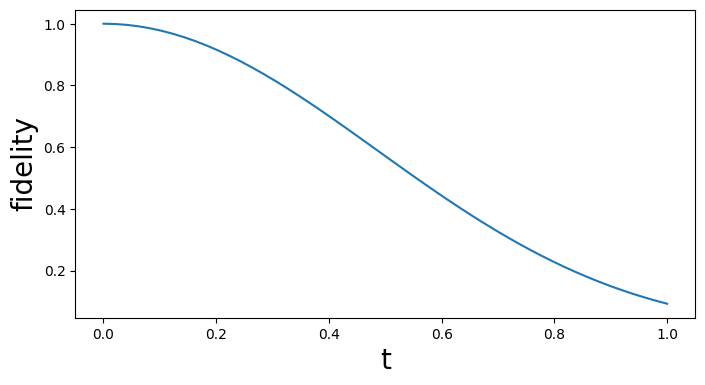

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(ts, fidelities)
plt.xlabel('t', fontsize=20)
plt.ylabel('fidelity', fontsize=20)
plt.show()

At `t=0`, the circuit parameters equal the ground state parameters, so the fidelity is

$$
f(t=0) = |\langle \psi(\lambda_0) | \psi(\lambda_0)\rangle|^2 = |\langle 0 | U^\dagger_{\lambda_0} U_{\lambda_0} | 0 \rangle|^2 = 1.
$$

As `t` increases, we move further from the ground state, and the fidelity decreases.

## Step 2: Define a Variational Quantum Deflation (VQD) algorithm

Recall that the exact solution gave us an excited state energy of `-9.0`

### First, we define an objective function for VQD.

Notice that we'll be using the Estimator for the original objective (expectation value of Hamiltonian) PLUS the Sampler to add in the fidelity term. We'll need to set a penalty $\beta$ for this fidelity contribution.

$$
  E(\lambda_1) = \langle \psi(\lambda_1)|H|\psi(\lambda_1)\rangle + \beta ~ |\langle \psi(\lambda_1) | \psi(\lambda_0)\rangle|^2
$$

In [16]:
# set penalty weight for overlap term
penalty = 25

# define objective for VQD
vqd_objective = lambda x: objective(x) + penalty*fidelity.run(qc, qc, ground_state_params, x)

### Next, we minimize our VQD objective

In [17]:
# run optimization to get first excited state
result = optimizer.minimize(vqd_objective, ground_state_params)
print(result)

{   'fun': -8.981815894508062,
    'jac': None,
    'nfev': 1000,
    'nit': 500,
    'njev': None,
    'x': array([ -3.13426295,  -3.14253715,  -6.28012314,   7.40274703,
         0.72579202,  27.20911057,  16.18476322,   1.95247083,
       -14.14898446,  -3.11917595, -29.84882787,  -4.03535317,
        -6.2590266 ,  15.78496767,  -4.73964622,   8.4574566 ])}


### Now that we've minimized the objective, we get a set of optimized circuit parameters for the exicted state. 

Let's plug these into the Estimator and get the corresponding (excited state) energy.

In [18]:
# determine energy
e_job = estimator([qc], [H], [result.x])
print(e_job)

EstimatorResult(values=array([-8.99704619]), metadata=[{}])


Recall that the exact energy of the first excited state is `-9`. We got pretty close!

### Let's see what the overlap (fidelity) of this excited state is with the ground state.

Recall that these two states *should* be orthogonal (zero overlap).

In [19]:
fid = fidelity.run(qc, qc, result.x, ground_state_params);
print(fid)

0.0006092119169222686


## Just like we saw with VQE, we can build VQD from Qiskit's interfaces.

Implement Qiskit's `Eigensolver` interface to reuse custom algorithm in Qiskit Applications stack.

In [20]:
from qiskit.algorithms import Eigensolver, EigensolverResult

In [21]:
class VQD(Eigensolver):
    
    def __init__(self, estimator, fidelity, circuit, optimizer, penalty=25, callback=None):
        
        # self._estimator = estimator
        self._fidelity = fidelity
        self._circuit = circuit
        self._optimizer = optimizer
        self._penalty = penalty
        self._callback = callback
        
    def compute_eigenvalues(self, operator, aux_operators=None):
                
        # compute ground state
        estimator = Estimator([self._circuit], [operator])
        energy = lambda x: estimator([self._circuit], [operator], [x]).values[0]
        x0 = np.random.rand(self._circuit.num_parameters)
        res_1 = self._optimizer.minimize(energy, x0)

        # compute first excited states
        overlap = lambda x: self._fidelity.run(self._circuit, self._circuit, res_1.x, x)
        def objective(x):
            value = energy(x) + self._penalty * overlap(x)
            if self._callback:
                self._callback(value)
            return value
        res_2 = self._optimizer.minimize(objective, res_1.x)
            
        # populate results
        result = EigensolverResult()
        result.eigenvalues = [estimator([self._circuit], [operator], [res_1.x]),
                              estimator([self._circuit], [operator], [res_2.x])]
        return result        

In [22]:
vqd = VQD(estimator, fidelity, qc, optimizer=SPSA(maxiter=1000))
result = vqd.compute_eigenvalues(H)
print(result)

{   'aux_operator_eigenvalues': None,
    'eigenstates': None,
    'eigenvalues': [   EstimatorResult(values=array([-12.91948381]), metadata=[{}]),
                       EstimatorResult(values=array([-9.08535856]), metadata=[{}])]}


## And, finally, let's pull everything together and use the Qiskit Runtime Primitives with Sessions.

In [23]:
from qiskit_ibm_runtime import (Session, Options, QiskitRuntimeService,
                                Sampler as RuntimeSampler, 
                                Estimator as RuntimeEstimator)

In [24]:
service = QiskitRuntimeService(channel='ibm_quantum')

In [25]:
from qiskit.algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=400)

In [26]:
with Session(service=service, backend='ibmq_qasm_simulator') as session:

    # prepare primitives
    rt_estimator = RuntimeEstimator(session=session)
    rt_sampler = RuntimeSampler(session=session)
    rt_fidelity = Fidelity(rt_sampler)

    # set up algorithm    
    rt_vqd = VQD(rt_estimator, rt_fidelity, qc, optimizer)
    
    # run algorithm
    result = rt_vqd.compute_eigenvalues(H)
    print(result)    

{   'aux_operator_eigenvalues': None,
    'eigenstates': None,
    'eigenvalues': [   EstimatorResult(values=array([-12.99999998]), metadata=[{}]),
                       EstimatorResult(values=array([-8.99999929]), metadata=[{}])]}


In [31]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.6.0'

In [32]:
from qiskit.tools.jupyter import *

%qiskit_version_table
%qiskit_copyright